In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

seaborn 0.10.1
pandas  1.0.4
numpy   1.18.4



In [2]:
import shap

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
inf_coverage = "/mnt/nvidia/pkr/code/type_1/data/hmp_mock_community/shi7_learning_tminx/coverage-200527.txt"

In [4]:
df_inf_coverage = pd.read_csv(inf_coverage, sep="\t")
headers = list(df_inf_coverage.columns)
headers[0] = "tax"
df_inf_coverage.columns = headers

In [5]:
df_inf_coverage["hits_in_clade"].median()

4.0

In [36]:
df_inf_coverage.loc[3, "tax"]

'k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__Methanobrevibacter_smithii'

In [33]:
df_inf_coverage

,tax,max_uncovered_region,percent_max_uncovered_region,percent_of_genome_covered,median_genome_size,hits_in_clade,unique_counts_of_clade,expected_coverage,ratio_covered_over_expected,truth
0,k__Archaea;p__Euryarchaeota;c__Halobacteria;o_...,59501.0,0.99997,0.00003,59503.0,6.0,58552.0,0.00010,0.32802,False
1,k__Archaea;p__Euryarchaeota;c__Halobacteria;o_...,80661.0,0.99998,0.00002,80663.0,18.0,80478.0,0.00022,0.11087,False
2,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,32869.0,0.77242,0.00009,42553.0,2.0,42536.0,0.00005,1.99922,False
3,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,18638.0,0.50287,0.03758,37063.0,732.0,37055.0,0.01956,1.92142,True
4,k__Archaea;p__Thaumarchaeota;c__;o__Nitrosopum...,31073.0,0.99798,0.00013,31136.0,2.0,31067.0,0.00006,1.99560,False
...,...,...,...,...,...,...,...,...,...,...
3686,k__Viruses;p__ssRNA_viruses;c__ssRNA_positive-...,156.0,0.98734,0.01266,158.0,3.0,158.0,0.01887,0.67090,False
3687,k__Viruses;p__unclassified_bacterial_viruses;c...,530.0,0.62796,0.02370,844.0,12.0,140.0,0.08243,0.28749,False
3688,k__Viruses;p__unclassified_bacterial_viruses;c...,534.0,0.62165,0.03609,859.0,17.0,123.0,0.12958,0.27851,False
3689,k__Viruses;p__unclassified_bacterial_viruses;c...,689.0,0.99711,0.00289,691.0,1.0,582.0,0.00172,1.68452,False


In [7]:
inf_truth = "/mnt/nvidia/pkr/code/type_1/data/hmp_mock_community/hmp_mock_truth_rg.txt"

In [8]:
df_truth = pd.read_csv(inf_truth, header=None, sep="\t")

In [9]:
df_truth.columns = ["id", "tax"]

In [10]:
df_truth["species"] = [";".join(s.split(";")[:-1]) for s in df_truth["tax"]]

In [11]:
s_truth = set(df_truth["species"])

In [12]:
df_inf_coverage["truth"] = [species in s_truth for species in df_inf_coverage.tax]

In [13]:
df_inf_coverage["truth"].sum()

26

In [14]:
len(s_truth)

27

In [15]:
# print the species not in mock
s_inf = set(df_inf_coverage.loc[df_inf_coverage["truth"], "tax"])
s_truth.difference(s_inf)

{'k__BacteriaPlasmid;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus_cereus'}

In [16]:
# we might want to drop all viruses and plasmids for this analysis

mask_plasmids = df_inf_coverage["tax"].apply(lambda x: "plasmid" in x.lower())
mask_virus = df_inf_coverage["tax"].apply(lambda x: "virus" in x.lower())

df_masked = df_inf_coverage.loc[(~(mask_plasmids | mask_virus))].copy()

In [17]:
df_masked.loc[df_masked["truth"], "percent_of_genome_covered"].mean()

0.06689999999999999

In [18]:
df_masked.loc[~df_masked["truth"], "percent_of_genome_covered"].mean()

0.00025343106850859884

In [19]:
df_masked.groupby("truth").mean()

,max_uncovered_region,percent_max_uncovered_region,percent_of_genome_covered,median_genome_size,hits_in_clade,unique_counts_of_clade,expected_coverage,ratio_covered_over_expected
truth,,,,,,,,
False,66216.679729,0.846448,0.000253,78014.573160,12.617705,80071.570059,0.000189,1.460133
True,32965.761905,0.496946,0.066900,66392.095238,2574.000000,97468.952381,0.037135,2.376270


In [20]:
import lightgbm

In [21]:
X = df_masked.loc[:, df_masked.columns.difference(["truth", "tax"])]
y = df_masked["truth"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#
# Create the LightGBM data containers
#
# categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]
# train_data = lightgbm.Dataset(x, label=y, categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)

In [22]:
#
# Train the model
#

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

lgb = lightgbm.LGBMClassifier(**parameters)
lgb.fit(X_train, y_train)

LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
               boosting='gbdt', feature_fraction=0.5, is_unbalance='true',
               learning_rate=0.05, metric='auc', objective='binary', verbose=0)

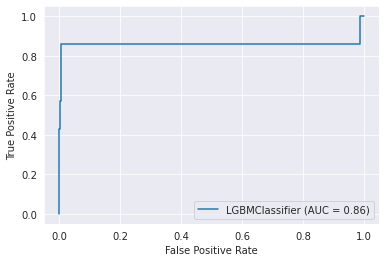

In [23]:
lgb_disp = plot_roc_curve(lgb, X_test, y_test)
plt.show()

In [24]:
# explain 10000 examples from the validation set
# each row is an explanation for a sample, and the last column in the base rate of the model
# the sum of each row is the margin (log odds) output of the model for that sample
shap_values = shap.TreeExplainer(lgb.booster_).shap_values(X_train)[0]
shap_values.shape
global_importances = np.abs(shap_values).mean(0)[:-1]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


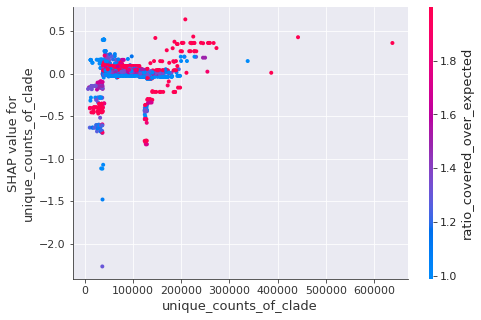

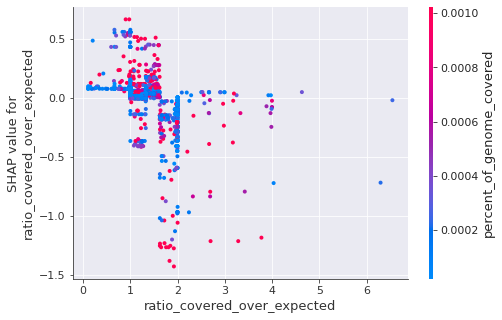

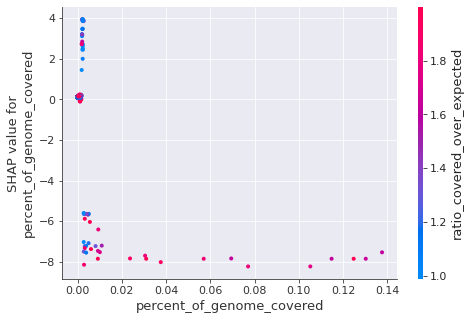

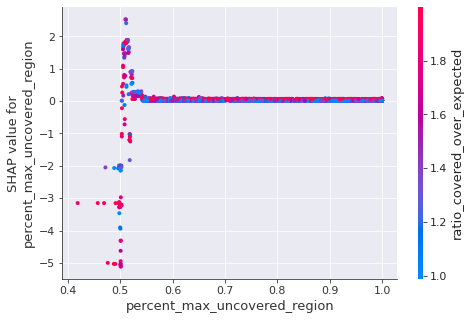

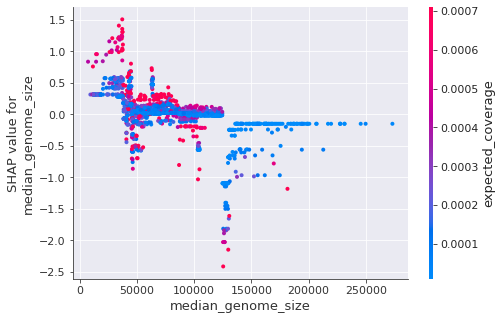

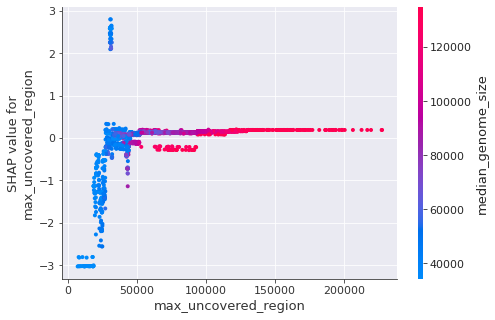

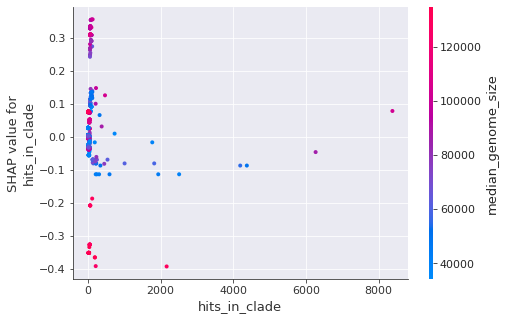

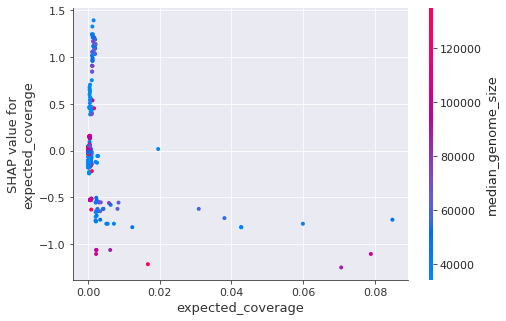

In [25]:
for i in reversed(range(len(X_train.columns))):
    shap.dependence_plot(i, shap_values, X_train)

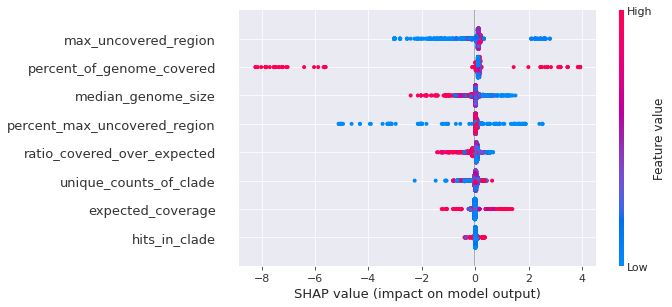

In [26]:
shap.summary_plot(shap_values, X_train)

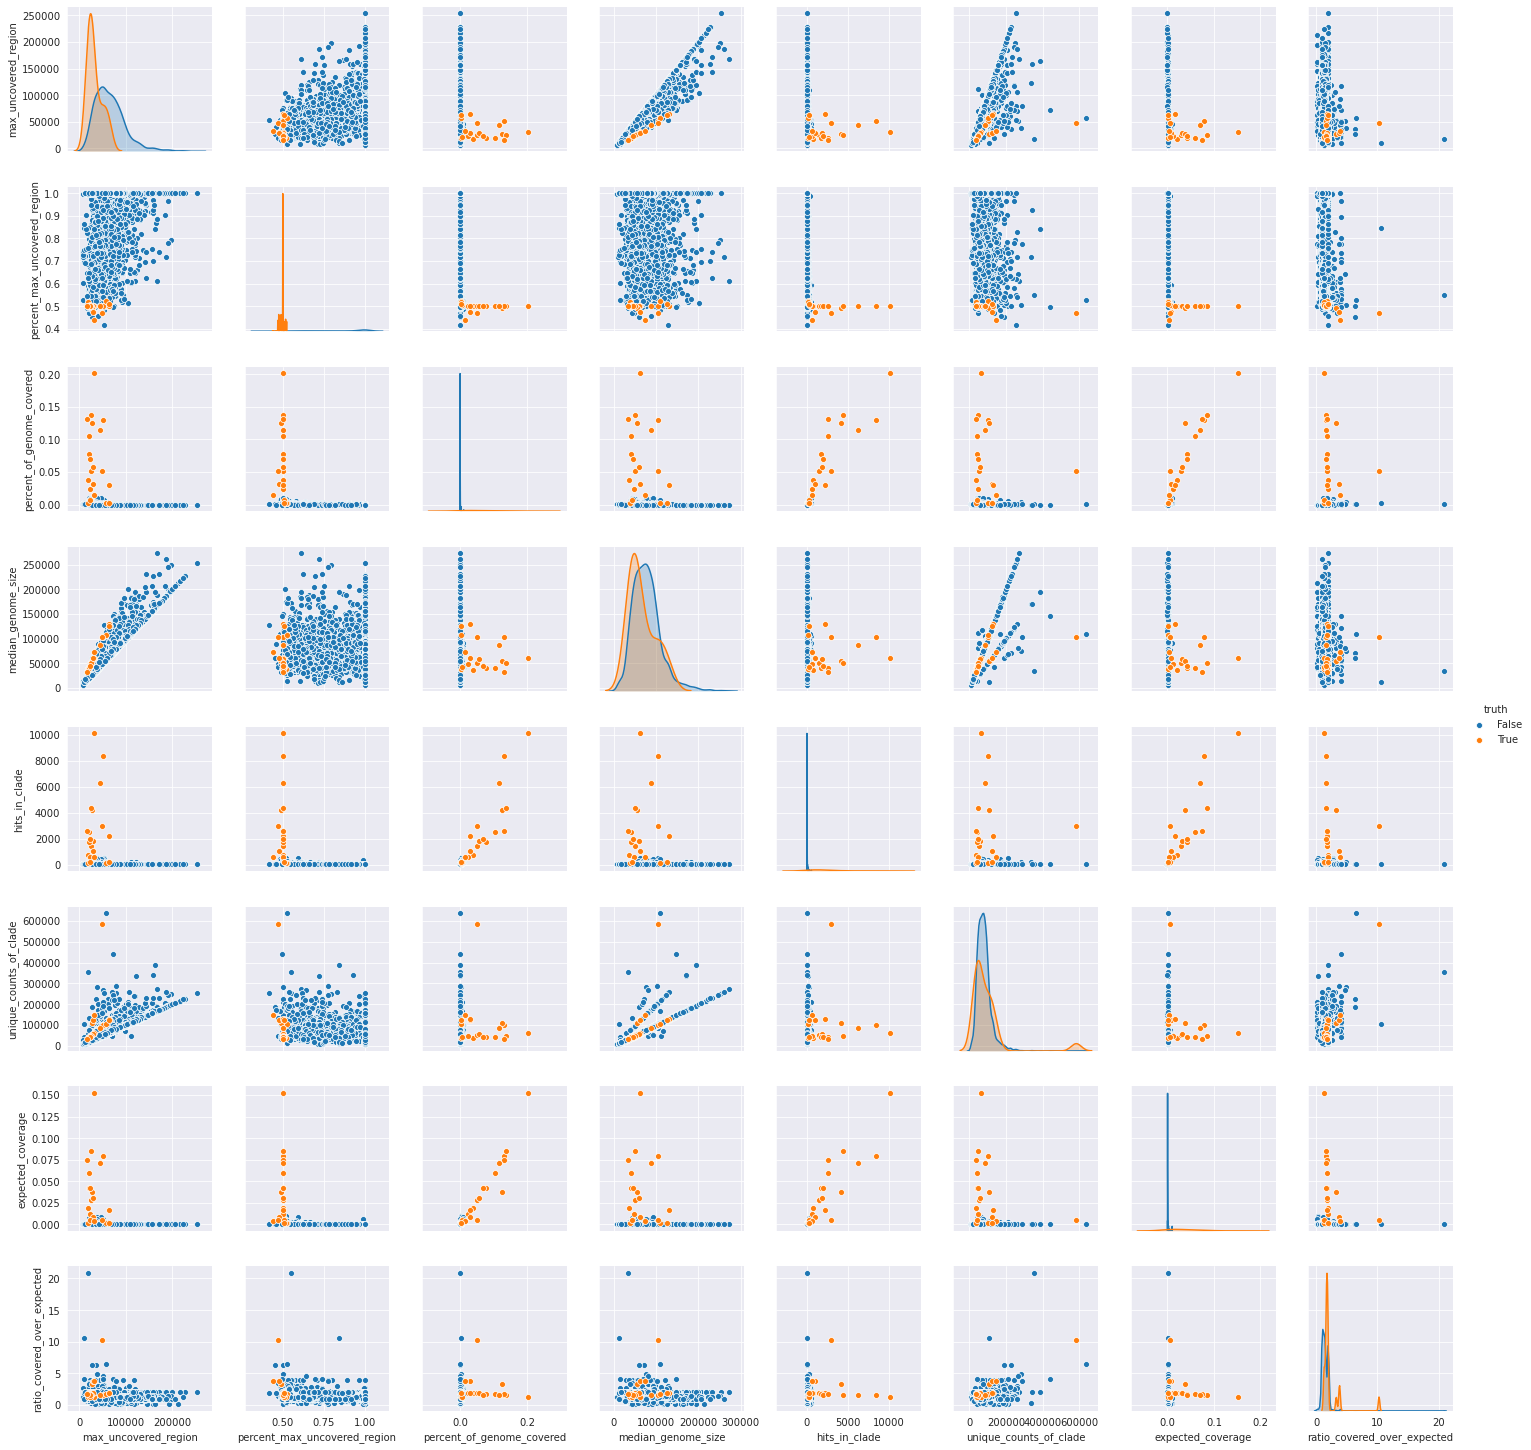

In [27]:
sns.pairplot(df_masked, hue="truth")

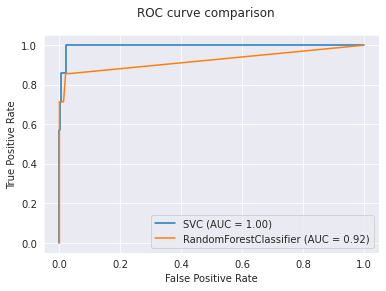

In [29]:
X = df_masked.loc[:, df_masked.columns.difference(["truth", "tax"])]
y = df_masked["truth"]

svc = SVC(random_state=42)
svc.fit(X_train, y_train)
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

svc_disp = plot_roc_curve(svc, X_test, y_test)
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=svc_disp.ax_)
rfc_disp.figure_.suptitle("ROC curve comparison")

plt.show()

In [30]:
joblib.dump(rfc, "/mnt/nvidia/pkr/code/type_1/data/hmp_mock_community/shi7_learning_tminx/rfc.pkl", compress=9)
joblib.dump

['/mnt/nvidia/pkr/code/type_1/data/hmp_mock_community/shi7_learning_tminx/rfc.pkl']